In [3]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [4]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\Ajay\Desktop\Tb -U net\TB_Chest_Radiography_Database", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 540 files [00:05, 96.60 files/s] 


In [5]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [6]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [7]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
2 folder and 0 images in output\test
0 folder and 11 images in output\test\Normal
0 folder and 17 images in output\test\Tuberculosis
2 folder and 0 images in output\train
0 folder and 162 images in output\train\Normal
0 folder and 243 images in output\train\Tuberculosis
2 folder and 0 images in output\val
0 folder and 43 images in output\val\Normal
0 folder and 64 images in output\val\Tuberculosis


In [8]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (512, 512, 3)


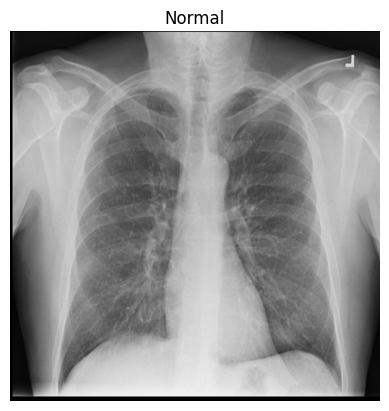

In [9]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Normal')

Image Shape : (512, 512)


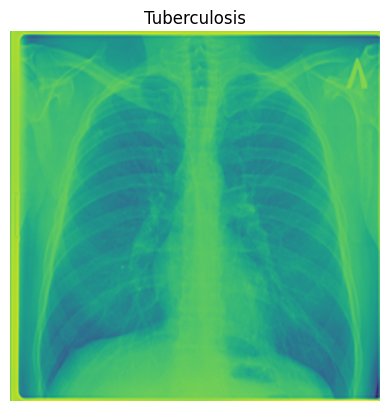

In [10]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Tuberculosis')

In [11]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [12]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 405 images belonging to 2 classes.
Found 107 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [13]:
train_data.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [14]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [15]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (405,)
val_y.shape:  (107,)
test_y.shape:  (28,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Directories
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

# Image dimensions and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

# Function to create U-Net model
def create_unet_model(input_shape, num_classes):
    # Define inputs
    inputs = Input(input_shape)
    
    # Contracting path (encoder)
    # Block 1
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Block 2
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Block 3
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Block 4
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Middle
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Expansive path (decoder)
    # Block 6
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    # Block 7
    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    # Block 8
    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    # Block 9
    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    # Output layer for classification (modified for multi-class classification)
    # Global average pooling to convert feature maps to features
    gap = tf.keras.layers.GlobalAveragePooling2D()(conv9)
    
    # Dense layers for classification
    dense1 = Dense(256, activation='relu')(gap)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(num_classes, activation='softmax')(dropout)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the U-Net model
unet_model = create_unet_model(input_shape, train_data.num_classes)
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
unet_model.summary()

# Train the model
print("Training U-Net Model...")
history = unet_model.fit(
    train_data,
    epochs=1,
    validation_data=val_data
)

# Save the model
unet_model.save("unet_model.h5")
print("U-Net Model saved as 'unet_model.h5'.")

# Evaluate the model on test data
print("Evaluating model on test data...")
test_results = unet_model.evaluate(test_data)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")

Found 405 images belonging to 2 classes.
Found 107 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 224, 224, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 224, 224, 64)         36928     ['conv2d_18[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 64)         0         ['c

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# Directories
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

# Image dimensions and batch size
input_shape = (128, 128, 3)  # Reduced image size for faster processing
batch_size = 64  # Increased batch size if your GPU can handle it

# Data generators with additional augmentation for better generalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Reduced image size
    batch_size=batch_size,
    class_mode='categorical')

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),  # Reduced image size
    batch_size=batch_size,
    class_mode='categorical')

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),  # Reduced image size
    batch_size=batch_size,
    class_mode='categorical')

# Function to create lightweight U-Net model
def create_lightweight_unet(input_shape, num_classes):
    # Define inputs
    inputs = Input(input_shape)
    
    # Contracting path (encoder) - Reduced filters
    # Block 1
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)  # Reduced from 64
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Block 2
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)  # Reduced from 128
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Block 3
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)  # Reduced from 256
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Middle (bottleneck)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)  # Reduced from 512
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.3)(conv4)  # Reduced dropout rate
    
    # Expansive path (decoder) - Reduced filters
    # Block 5
    up5 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(drop4)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = BatchNormalization()(conv5)
    
    # Block 6
    up6 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    
    # Block 7
    up7 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    
    # Global average pooling for classification
    gap = tf.keras.layers.GlobalAveragePooling2D()(conv7)
    
    # Dense layers for classification
    dense1 = Dense(128, activation='relu')(gap)  # Reduced from 256
    dropout = Dropout(0.3)(dense1)  # Reduced dropout
    outputs = Dense(num_classes, activation='softmax')(dropout)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the lightweight U-Net model
unet_model = create_lightweight_unet(input_shape, train_data.num_classes)
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
unet_model.summary()

# Define callbacks to speed up training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)
]

# Train the model with fewer epochs and callbacks
print("Training Lightweight U-Net Model...")
history = unet_model.fit(
    train_data,
    epochs=5,  # Reduced number of epochs
    validation_data=val_data,
    callbacks=callbacks
)

# Save the model
unet_model.save("lightweight_unet_model.h5")
print("Lightweight U-Net Model saved as 'lightweight_unet_model.h5'.")

# Evaluate the model on test data
print("Evaluating model on test data...")
test_results = unet_model.evaluate(test_data)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")

Found 405 images belonging to 2 classes.
Found 107 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                     

C:\Users\Ajay\anaconda3\envs\py310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Lightweight U-Net Model saved as 'lightweight_unet_model.h5'.
Evaluating model on test data...
1/1 [==============================] - 1s 784ms/step - loss: 0.6588 - accuracy: 0.6429
Test Loss: 0.6588
Test Accuracy: 0.6429


1/1 [==============================] - 0s 37ms/step


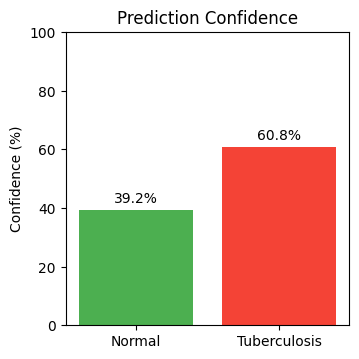

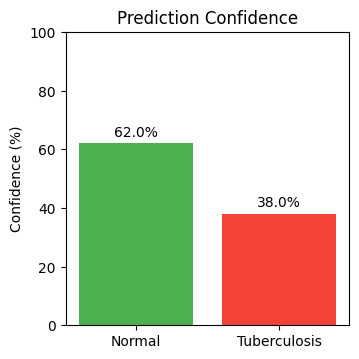

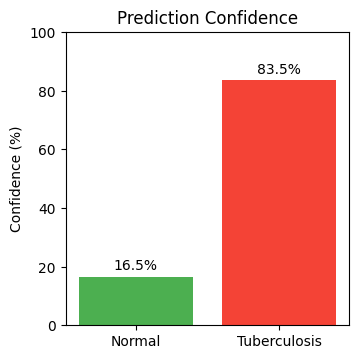

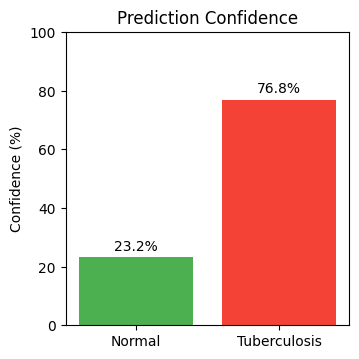

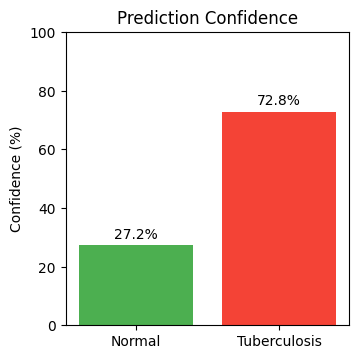

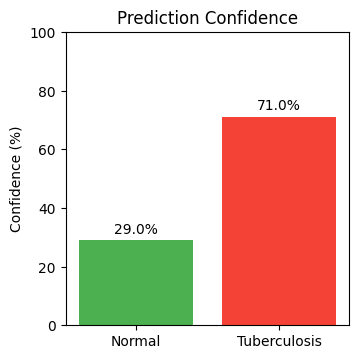

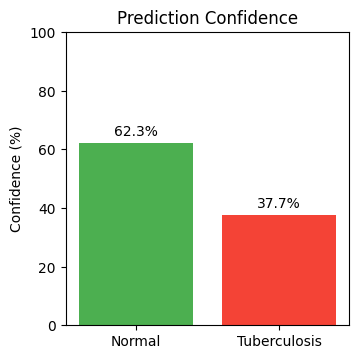

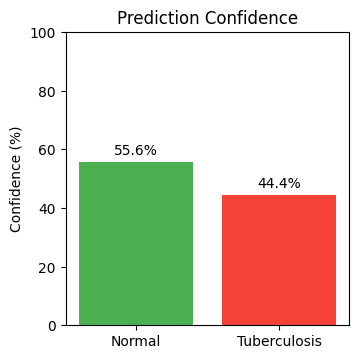

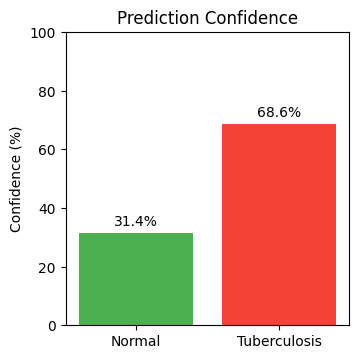

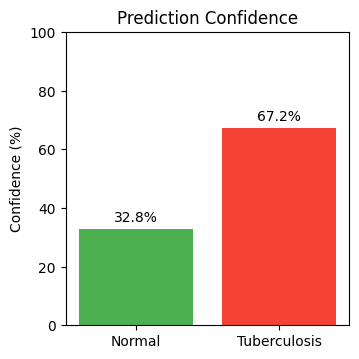

In [17]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class SimpleTBPredictor:
    def __init__(self, root):
        self.root = root
        self.root.title("Tuberculosis Detector")
        self.root.geometry("800x600")
        self.root.configure(bg="#f0f0f0")
        
        # Class indices
        self.class_indices = {'Normal': 0, 'Tuberculosis': 1}
        self.class_names = {v: k for k, v in self.class_indices.items()}
        
        # Load model automatically
        try:
            self.model = load_model("lightweight_unet_model.h5")
            self.status_var = tk.StringVar()
            self.status_var.set("Model loaded successfully")
        except Exception as e:
            self.status_var = tk.StringVar()
            self.status_var.set(f"Error loading model: {str(e)}")
            messagebox.showerror("Error", f"Failed to load model: {str(e)}")
        
        # Main frame
        main_frame = tk.Frame(root, bg="#f0f0f0")
        main_frame.pack(pady=10, fill="both", expand=True)
        
        # Upload button
        self.upload_btn = tk.Button(main_frame, text="Upload Image", command=self.upload_image,
                                    bg="#2196F3", fg="white", font=("Arial", 12), padx=20, pady=10)
        self.upload_btn.pack(pady=20)
        
        # Display frame (image and result side by side)
        display_frame = tk.Frame(main_frame, bg="#f0f0f0")
        display_frame.pack(fill="both", expand=True, padx=20)
        
        # Image display
        self.image_frame = tk.Frame(display_frame, bg="white", width=350, height=350)
        self.image_frame.pack(side=tk.LEFT, padx=10, fill="both", expand=True)
        self.image_label = tk.Label(self.image_frame, bg="white")
        self.image_label.pack(fill="both", expand=True)
        
        # Results display
        self.result_frame = tk.Frame(display_frame, bg="#f0f0f0", width=350)
        self.result_frame.pack(side=tk.RIGHT, padx=10, fill="both", expand=True)
        
        # Result label
        self.result_label = tk.Label(self.result_frame, text="No prediction yet", 
                                    font=("Arial", 16, "bold"), bg="#f0f0f0")
        self.result_label.pack(pady=20)
        
        # Result details frame
        self.details_frame = tk.Frame(self.result_frame, bg="#f0f0f0")
        self.details_frame.pack(fill="both", expand=True)
        
        # Status bar
        status_bar = tk.Label(root, textvariable=self.status_var, bd=1, relief=tk.SUNKEN, anchor=tk.W)
        status_bar.pack(side=tk.BOTTOM, fill=tk.X)
    
    def upload_image(self):
        """Upload and process an image"""
        file_path = filedialog.askopenfilename(
            title="Select Image", 
            filetypes=(("Image files", "*.jpg *.jpeg *.png"), ("All files", "*.*"))
        )
        
        if not file_path:
            return
            
        try:
            # Display image
            self.display_image(file_path)
            
            # Process image and make prediction
            self.predict_image(file_path)
        except Exception as e:
            self.status_var.set(f"Error: {str(e)}")
            messagebox.showerror("Error", str(e))
    
    def display_image(self, img_path):
        """Display the selected image"""
        # Open and resize image for display
        img = Image.open(img_path)
        img.thumbnail((350, 350))
        
        # Convert to PhotoImage
        photo_img = ImageTk.PhotoImage(img)
        
        # Update image label
        self.image_label.config(image=photo_img)
        self.image_label.image = photo_img  # Keep reference
    
    def predict_image(self, img_path):
        """Process image and display prediction results"""
        # Clear previous results
        for widget in self.details_frame.winfo_children():
            widget.destroy()
        
        # Preprocess image
        img = image.load_img(img_path, target_size=(128, 128))  # Match model input size
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Make prediction
        predictions = self.model.predict(img_array)
        predicted_class_idx = np.argmax(predictions[0])
        predicted_class = self.class_names[predicted_class_idx]
        confidence = predictions[0][predicted_class_idx] * 100
        
        # Update result label
        if predicted_class == "Normal":
            self.result_label.config(text="NORMAL", fg="#4CAF50")
        else:
            self.result_label.config(text="TUBERCULOSIS DETECTED", fg="#F44336")
        
        # Create confidence visualization
        self.create_confidence_chart(predictions[0])
        
        # Update status
        self.status_var.set(f"Prediction: {predicted_class} with {confidence:.2f}% confidence")
    
    def create_confidence_chart(self, probabilities):
        """Create and display confidence visualization"""
        # Create figure for the chart
        fig, ax = plt.subplots(figsize=(4, 3))
        
        # Bar chart data
        classes = list(self.class_names.values())
        colors = ['#4CAF50', '#F44336']  # Green for Normal, Red for TB
        
        # Create bar chart
        bars = ax.bar(classes, probabilities*100, color=colors)
        
        # Customize appearance
        ax.set_ylim(0, 100)
        ax.set_ylabel('Confidence (%)')
        ax.set_title('Prediction Confidence')
        
        # Add percentage labels
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}%',
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),
                      textcoords="offset points",
                      ha='center', va='bottom')
        
        # Create canvas in the details frame
        canvas = FigureCanvasTkAgg(fig, master=self.details_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True, pady=10)

# Run the application
if __name__ == "__main__":
    root = tk.Tk()
    app = SimpleTBPredictor(root)
    root.mainloop()